In [1]:
import sys
import numpy as np
from numpy import genfromtxt
import tkinter as tk
from tkinter import filedialog
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy import stats
from ipfx import feature_extractor
from ipfx import subthresh_features as subt
from ipfx import feature_vectors as fv
from ipfx.sweep import Sweep
from sklearn.preprocessing import minmax_scale
from pyAPisolation.loadABF import loadABF
import sklearn.preprocessing
import pyabf
import logging
import glob
method='trf'

C:\Users\SMest\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\SMest\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\SMest\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
import autograd.numpy as np
from autograd import grad



In [ ]:

def exp_grow(t, a, b, alpha):
    return a - b * np.exp(-alpha * t)

def exp_grow_2p(t, a, b1, alphaFast, b2, alphaSlow):
    return a - b1 * np.exp(-alphaFast * t) - b2*np.exp(-alphaSlow*t) 

def exp_grow_gp(t, Y0, Plateau, PercentFast, KFast, KSlow):
    #graphpad style two phase decay
    SpanFast=(Y0-Plateau)*PercentFast*.01

    SpanSlow=(Y0-Plateau)*(100-PercentFast)*.01

    return Plateau + SpanFast*np.exp(-KFast*t) + SpanSlow*np.exp(-KSlow*t)


In [6]:
def exp_growth_factor(dataT,dataV,dataI, end_index=300):
    #try:
        
        diff_I = np.diff(dataI)
        upwardinfl = np.argmax(diff_I)

        #Compute out -50 ms from threshold
        dt = dataT[1] - dataT[0]
        offset = 0.0005/ dt 

        end_index = int(end_index - offset)


        
        upperC = np.amax(dataV[upwardinfl:end_index])
        lowerC  = np.amin(dataV[upwardinfl:end_index])
        diffC = np.abs(lowerC - upperC)
        t1 = dataT[upwardinfl:end_index] - dataT[upwardinfl]
        #curve = curve_fit(exp_grow, t1, dataV[upwardinfl:end_index], maxfev=50000, bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))[0]
        #curve2 = curve_fit(exp_grow_2p, t1, dataV[upwardinfl:end_index], maxfev=50000,method='trf', bounds=([upperC-5,  0, 10,  0,  -np.inf], [upperC+5, diffC, np.inf, diffC,np.inf]), #xtol=None, gtol=None, ftol=1e-12)[0]
        #curve2 = curve_fit(exp_grow_gp, t1, dataV[upwardinfl:end_index], maxfev=50000,method='trf', bounds=([lowerC-5,  upperC-5, -np.inf,  -np.inf,  -np.inf], [lower+5, upperC+5, np.inf,np.inf,np.inf]),  xtol=None, gtol=None, ftol=1e-12)[0]
        coeff = np.polyfit(t1, dataV[upwardinfl:end_index], 3)
        poly_y = np.polyval(coeff, t1)
        curve2 = np.hstack((coeff))
        tau1 = curve2[2]
        tau2 = curve2[3]
        tau_idx = [2, 3]
        fast = tau_idx[np.argmin([tau1, tau2])]
        slow = tau_idx[np.argmax([tau1, tau2])]
        
        


        #plt.subplot(1,2,1)
        plt.plot(t1, dataV[upwardinfl:end_index], c='k', alpha=0.5)
        plt.plot(t1, poly_y, label=f'2 phase fit', c='r', alpha=0.5)
        
        plt.title(f" CELL will tau1 {curve2[fast]} and tau2 {curve2[slow]}")
        #plt.subplot(1,2,2)
        plt.legend()
        #plt.twinx()
        #plt.subplot(1,2,2)
        #dy = curve_detrend(t1, dataV[upwardinfl:end_index], curve2)
         #signal.savgol_filter(nt1p.diff(dataV[upwardinfl:end_index])/np.diff(t1), 71, 2, mode='mirror')
        #plt.plot(t1,dy)
        
    
        return curve2, 0
    #except:
        return [np.nan, np.nan, np.nan, np.nan, np.nan]

In [7]:


f1 = grad(exp_grow_2p)  # 1st derivative of f
f2 = grad(f1) # 2nd derivative of f

def curvature(x, a, b1, alphaFast, b2, alphaSlow):
        return np.abs(f2(x, a, b1, alphaFast, b2, alphaSlow))*(1 + f1(x, a, b1, alphaFast, b2, alphaSlow)**2)**-1.5
    
    
def curvature_real(dy, ddy):
        return abs(dy)*(1 + ddy**2)**-1.5
    
def curvature_splines(x, y=None, error=0.1, smoothing=None):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
         or
         y=None and
         x is a numpy.array(dtype=complex) shape (n_points, )
         In the second case the curve is represented as a np.array
         of complex numbers.
    error : float
        The admisible error when interpolating the splines
    Returns
    -------
    curvature: numpy.array shape (n_points, )
    Note: This is 2-3x slower (1.8 ms for 2000 points) than `curvature_gradient`
    but more accurate, especially at the borders.
    """

    # handle list of complex case
    if y is None:
        x, y = x.real, x.imag

    t = np.arange(x.shape[0])
    std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std), s=smoothing)
    fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std), s=smoothing)

    xˈ = fx.derivative(1)(t)
    xˈˈ = fx.derivative(2)(t)
    yˈ = fy.derivative(1)(t)
    yˈˈ = fy.derivative(2)(t)
    curvature = (xˈ* yˈˈ - yˈ* xˈˈ) / np.power(xˈ** 2 + yˈ** 2, 3 / 2)
    return curvature
    

def derivative(x,y):
    return np.diff(y)/np.diff(x)


def curve_detrend(x,y, curve2):
    test = curvature_splines(x, signal.savgol_filter(y, 51, 1), error=1, smoothing=25)
    cy = np.array([curvature(xi, *curve2) for xi in x])
    #detrend using first and last point
    lin_res = stats.linregress([x[0], x[-1]], [cy[0], cy[-1]])
    trend = x*lin_res.slope + lin_res.intercept
    #plt.plot(x,trend)
    detrended_data = cy - trend
    return detrended_data

In [8]:
files = glob.glob('C:\\Users\\SMest\\Documents\\clustering-data\\\All IC1s\\*.abf', recursive=True)

In [9]:
cell_type_df = pd.read_csv("C:\\Users\\SMest\\Documents\\clustering-data\\MARM_PVN_IC1\\spike_count_sort_out.csv")
print(cell_type_df.head)
file_names = cell_type_df['filename'].to_numpy()
cell_type_label = cell_type_df['cell_label'].to_numpy()

<bound method NDFrame.head of             filename  label  cell_label  CRH_label  Sag Ratio 001  \
0    2020_01_16_0003      2          -1         -1       0.072335   
1    2020_01_16_0011      1           1         -1       0.053301   
2    2020_01_16_0020      2           3         -1       0.183200   
3    2020_01_16_0025      2          -1         -1       0.200844   
4    2020_01_16_0029      0          -1          0       0.044166   
..               ...    ...         ...        ...            ...   
152         21311038      1           0         -1       0.065753   
153         21311047      1           1         -1       0.069595   
154         21311063      5           1         -1       0.291042   
155         21311074      1          -1         -1       0.123829   
156         21311084      1           1         -1       0.290186   

     Sag Ratio 002  Sag Ratio 003  Sag Ratio 004  Sag Ratio 005  \
0         0.480277       1.081981       1.528664       1.856069   
1      

0
fail
1
[[298746.8657 -33387.7409   1362.8684    -67.4285     -0.0066      0.    ]]
(6,)


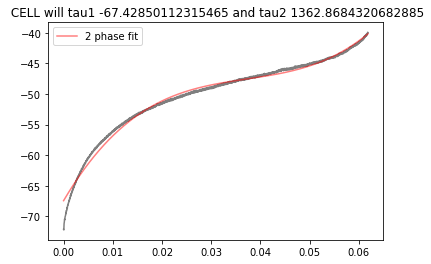

fail
2
[[ 67466.973  -16198.7498   1653.1248   -121.4653     -0.0025      0.0002]]
(6,)


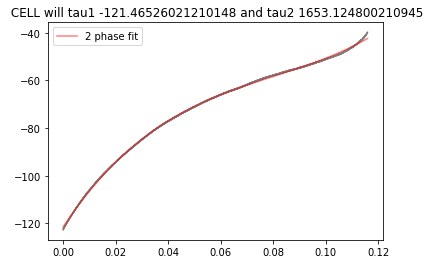

fail
3
[[35042.732  -8248.3403   825.2776   -90.8618    -0.0051     0.0003]]
(6,)


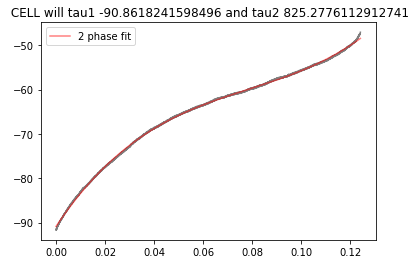

fail
4
[[ 5970.4467 -3248.0956   657.7602   -90.909     -0.0028     0.0031]]
(6,)


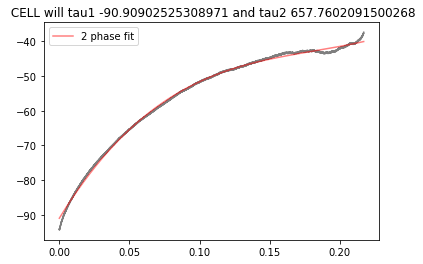

fail
5
fail
6
[[12201.6292 -4823.0892   650.0058   -72.7064    -0.0039     0.0008]]
(6,)


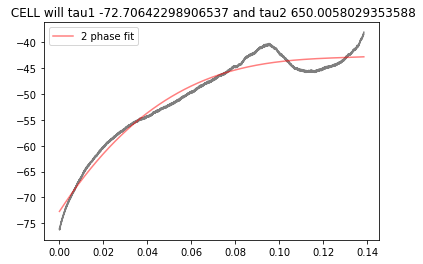

fail
7
fail
8
fail
9
[[328103.2378 -39566.4857   1619.5832    -65.1904     -0.0051      0.    ]]
(6,)


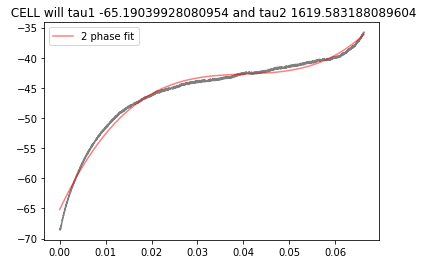

fail
10
[[122444.6991 -22056.1872   1449.1606    -75.938      -0.0038      0.    ]]
(6,)


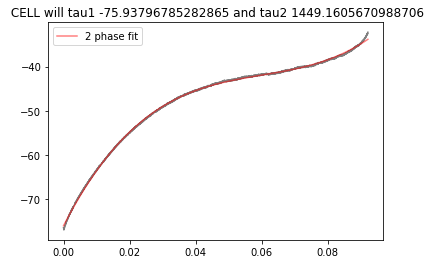

fail
11
[[331709.015  -33430.7327   1663.7574    -77.4089     -0.006       0.    ]]
(6,)


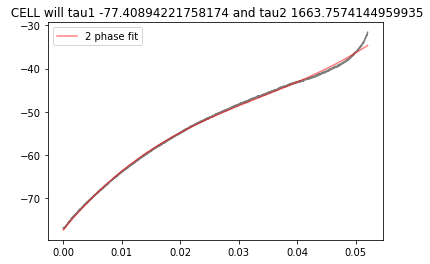

fail
12
fail
13
[[335041.4085 -42067.3095   1906.3545    -72.7674     -0.0042      0.    ]]
(6,)


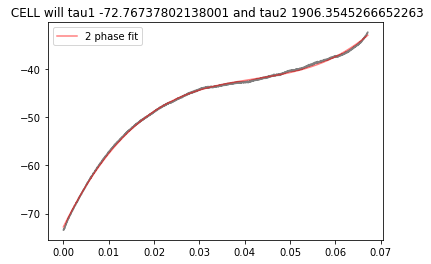

fail
14
[[17715.5088 -6408.7961   750.1165   -69.9612    -0.0037     0.0005]]
(6,)


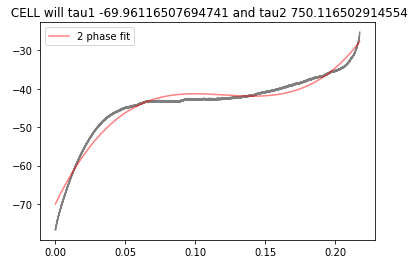

fail
15
[[26727.9269 -7541.9255   701.6578   -65.421     -0.0051     0.0002]]
(6,)


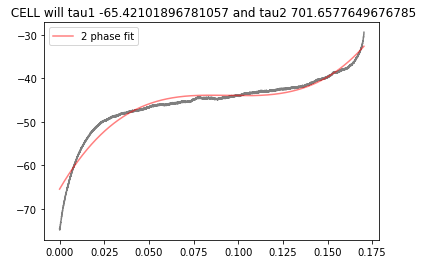

fail
16
fail
17
[[633911.2075 -44874.2507   1533.6258    -69.5081     -0.0092      0.    ]]
(6,)


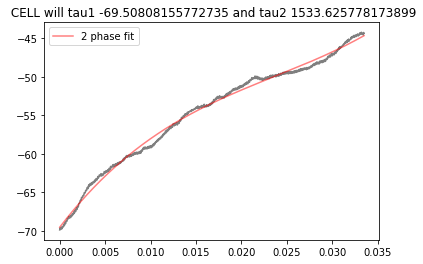

fail
18
[[24954.0899 -6635.5625   651.8728   -82.0399    -0.0058     0.0003]]
(6,)


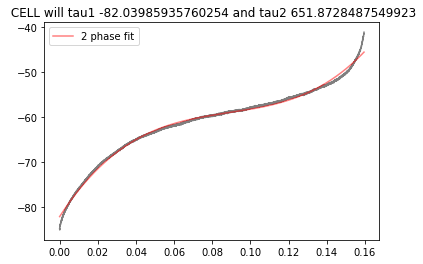

fail
19
[[ 2939.4408 -1791.6611   372.8828   -74.9257    -0.0044     0.0053]]
(6,)


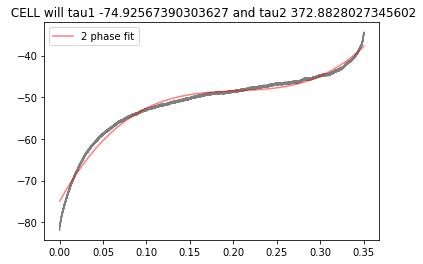

fail
20
[[117264.7779 -17554.1777   1172.4374    -90.8084     -0.0057      0.0001]]
(6,)


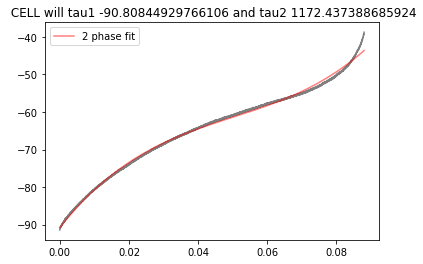

fail
21
[[21227.9249 -4966.0656   523.7632   -74.608     -0.0082     0.0004]]
(6,)


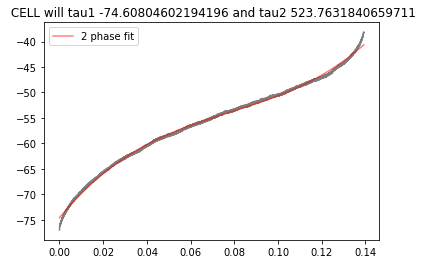

fail
22
[[2703257.3589 -103629.9247    1660.6572     -66.5201      -0.0157
        0.    ]]
(6,)


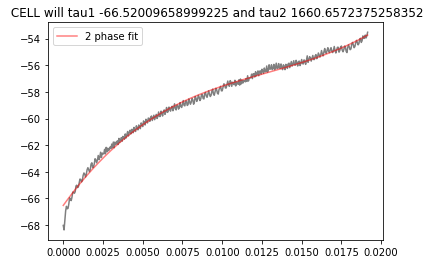

fail
23
[[ 44707.502  -11170.777     975.0179    -72.3931     -0.0041      0.0001]]
(6,)


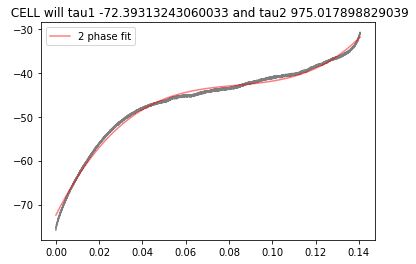

fail
24
[[530361.5825 -58549.9005   2162.4899    -65.408      -0.0042      0.    ]]
(6,)


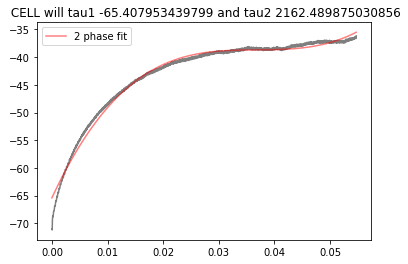

fail
25
[[121776.233  -18778.0331   1124.9218    -69.5257     -0.0058      0.    ]]
(6,)


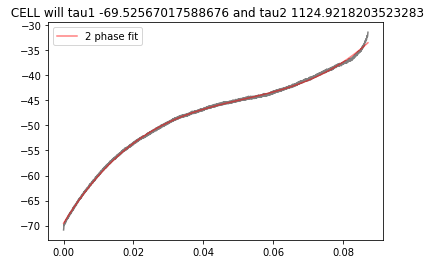

fail
26
[[29382.7937 -8697.0777   844.6401   -69.5407    -0.004      0.0002]]
(6,)


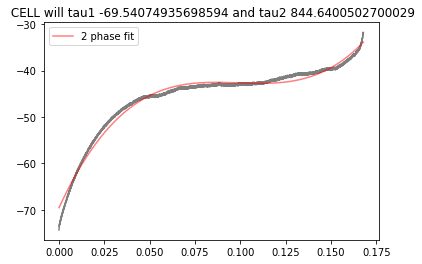

fail
27
[[27308.6333 -7538.5069   698.5623   -64.0144    -0.0052     0.0002]]
(6,)


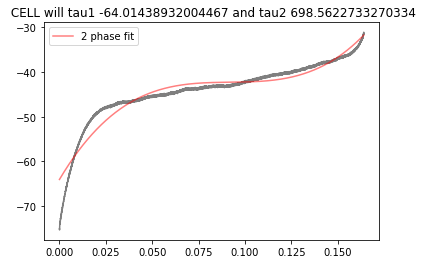

fail
28
[[ 58824.1159 -13984.7646   1152.4696    -75.7413     -0.0036      0.0001]]
(6,)


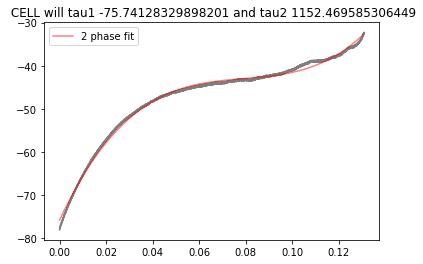

fail
29
[[36872.9088 -9416.9308   930.4386   -81.7106    -0.0042     0.0002]]
(6,)


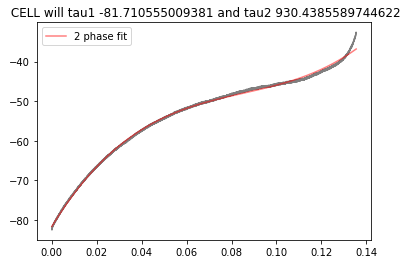

fail


In [10]:
curves = []
label = []
ids = []
max_curve = []
for i, f in enumerate(files[:30]):
        print(i)
    #try:
        base = os.path.basename(f)
        base = base.split(".")[0]
        if base in file_names:
            x, y, c = loadABF(f)
            
            temp_curves =[]
            #plt.clf()
            iterd = 0
            for sweepX, sweepY, sweepC in zip(x,y,c):
                spikext = feature_extractor.SpikeFeatureExtractor(filter=0, end=1.25)
                res = spikext.process(sweepX, sweepY, sweepC)
                if res.empty==False and iterd < 1:
                    iterd += 1
                    spike_time = res['threshold_index'].to_numpy()[0]
                    #plt.figure(num=2)
                    curve, max_dy = exp_growth_factor(sweepX, sweepY, sweepC, spike_time)
                    max_curve.append(max_dy)
                    temp_curves.append(curve)
            temp_curves = np.vstack(temp_curves)
            div = np.ravel((temp_curves[:,0]) / (temp_curves[:,1]) / (temp_curves[:,2])).reshape(-1,1)
            
            sum_height= (temp_curves[:,1] + temp_curves[:,3])
            ratio = (temp_curves[:,2] / (temp_curves[:,1] / sum_height)) / (temp_curves[:,0] / (temp_curves[:,3] / sum_height))
            ratio = np.ravel(ratio).reshape(-1,1)
            temp_curves = np.hstack([temp_curves, div, ratio])
            print(temp_curves)
            meanC = np.nanmean(temp_curves, axis=0)
            print(meanC.shape)
            curves.append(meanC)
            label_idx = np.argwhere(file_names==base)
            

            label.append(cell_type_label[label_idx])
            
            ids.append(base)
            plt.savefig(f+".png")
            plt.show()
            
            plt.close()
    #except:
        print("fail")
curves = np.vstack(curves)

In [11]:
#lab = sklearn.preprocessing.LabelEncoder()
#int_lab = lab.fit_transform(label)
print(curves)
label = np.ravel(label).reshape(-1,1)
div = np.ravel((curves[:,2]) / (curves[:,4])).reshape(-1,1)
print(div)
sum_height= (curves[:,1] + curves[:,3])
ratio = (curves[:,2] / (curves[:,1]/sum_height)) / (curves[:,4] / (curves[:,3]/sum_height))
ratio = np.ravel(ratio).reshape(-1,1)
curves_out = np.hstack([curves, div, ratio, label])
np.savetxt('curves.csv', curves_out, fmt='%.8f', delimiter=',')
np.savetxt('curves_id.csv', ids, fmt='%s', delimiter=',')
print(curves)

[[298746.8657 -33387.7409   1362.8684    -67.4285     -0.0066      0.    ]
 [ 67466.973  -16198.7498   1653.1248   -121.4653     -0.0025      0.0002]
 [ 35042.732   -8248.3403    825.2776    -90.8618     -0.0051      0.0003]
 ...
 [ 27308.6333  -7538.5069    698.5623    -64.0144     -0.0052      0.0002]
 [ 58824.1159 -13984.7646   1152.4696    -75.7413     -0.0036      0.0001]
 [ 36872.9088  -9416.9308    930.4386    -81.7106     -0.0042      0.0002]]
[[-207582.8842]
 [-656147.6134]
 [-160312.9985]
 ...
 [-134708.6947]
 [-315761.1521]
 [-221094.2158]]
[[298746.8657 -33387.7409   1362.8684    -67.4285     -0.0066      0.    ]
 [ 67466.973  -16198.7498   1653.1248   -121.4653     -0.0025      0.0002]
 [ 35042.732   -8248.3403    825.2776    -90.8618     -0.0051      0.0003]
 ...
 [ 27308.6333  -7538.5069    698.5623    -64.0144     -0.0052      0.0002]
 [ 58824.1159 -13984.7646   1152.4696    -75.7413     -0.0036      0.0001]
 [ 36872.9088  -9416.9308    930.4386    -81.7106     -0.0042 

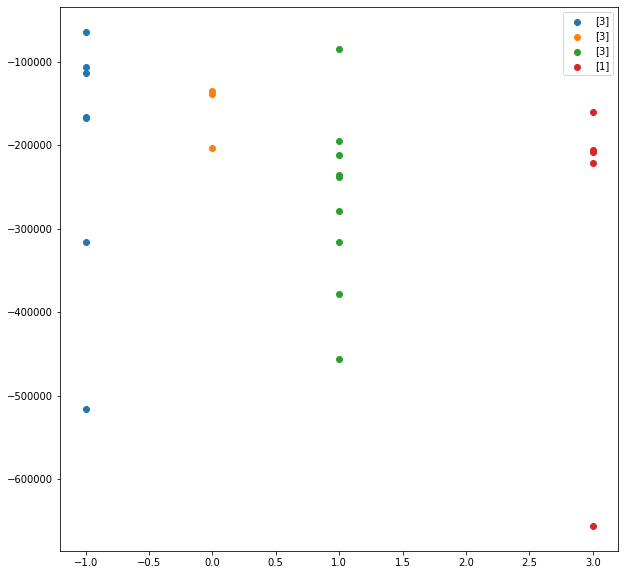

In [12]:
means = []
plt.figure(figsize=(10,10))
plt.clf()
for x in np.unique(label).astype(np.int32):
    idx = np.argwhere(label[:,0]==x).astype(np.int32)
    mcur = curves[idx]
    plt.scatter(np.full(len(idx),  x),  (curves[idx,2]) / (curves[idx,4]), label=label[x])
    means.append(np.nanmean((curves[idx,2]) / (curves[idx,4])))
plt.legend()
#plt.ylim(0,1)

In [13]:
print(means)

[-206995.67147260593, -159061.30127917536, -265920.85428191506, -290182.505728723]


In [14]:
1=1
curves = []
label = []
ids = []
for i, f in enumerate(files[:38]):
    print(i)
    x, y, c = loadABF(f)
    d_name = os.path.dirname(f)
    base = os.path.basename(f)
    ids.append(base)
    label.append(d_name)
    dfs = []
    temp_curves
    plt.clf()
    for sweepX, sweepY, sweepC in zip(x,y,c):
        spikext = feature_extractor.SpikeFeatureExtractor(filter=0)
        res = spikext.process(sweepX, sweepY, sweepC)
        dfs.append(res)
        if res.empty==False:
            if len(non_empty_df) > 1:
                sweep_to_use = non_empty_df[1]
            else:
                sweep_to_use = non_empty_df[-1]
    non_empty_df = np.nonzero(np.invert([df.empty for df in dfs]))[0]
    
    
    try:
        spike_time = dfs[sweep_to_use]['threshold_index'].to_numpy()[0]
        curve = exp_growth_factor(x[sweep_to_use,:], y[sweep_to_use,:], c[sweep_to_use,:], spike_time)
        curves.append(curve)
    except:
        curves.append([np.nan, np.nan, np.nan, np.nan, np.nan])
    plt.show()
print(non_empty_df)

SyntaxError: can't assign to literal (<ipython-input-14-3b77a170223a>, line 1)